<h2> Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения</h2>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
# импортируем необходимые библиотеки для разведочного анализа
sns.set_style('whitegrid')

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

In [4]:
data=pd.read_csv('ebw_data.csv') #загружаем наш датасет
data.sample(5)

IW   IF     VW  FP  Depth  Width
50  44  146  9.000  60  1.240  1.800
61  43  146  9.000  60  1.240  1.800
41  47  140 10.000  80  1.220  1.820
31  47  139  4.500  80  1.360  2.480
56  44  146  9.000  60  1.200  1.760

<div class="alert alert-block alert-info"><h3>Поиск пропущенных значений</h3> </div> 


In [5]:
data.isna().sum() #Проверка на наличие пропусков в данных
#пропусков нет

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

<div class="alert alert-block alert-info"><h3>Разведочный анализ данных</h3> </div> 

In [6]:
data.describe().iloc[1:] #убрали неинформативную строку count
#в целом мы видиим разный масштаб данных, что говорит нам о необходимости проведения нормализации

IW      IF     VW      FP  Depth  Width
mean 45.667 141.333  8.639  78.333  1.196  1.970
std   1.678   5.146  2.061  21.494  0.225  0.279
min  43.000 131.000  4.500  50.000  0.800  1.680
25%  44.000 139.000  8.000  60.000  1.080  1.760
50%  45.500 141.000  9.000  80.000  1.200  1.840
75%  47.000 146.000 10.000  80.000  1.290  2.050
max  49.000 150.000 12.000 125.000  1.760  2.600

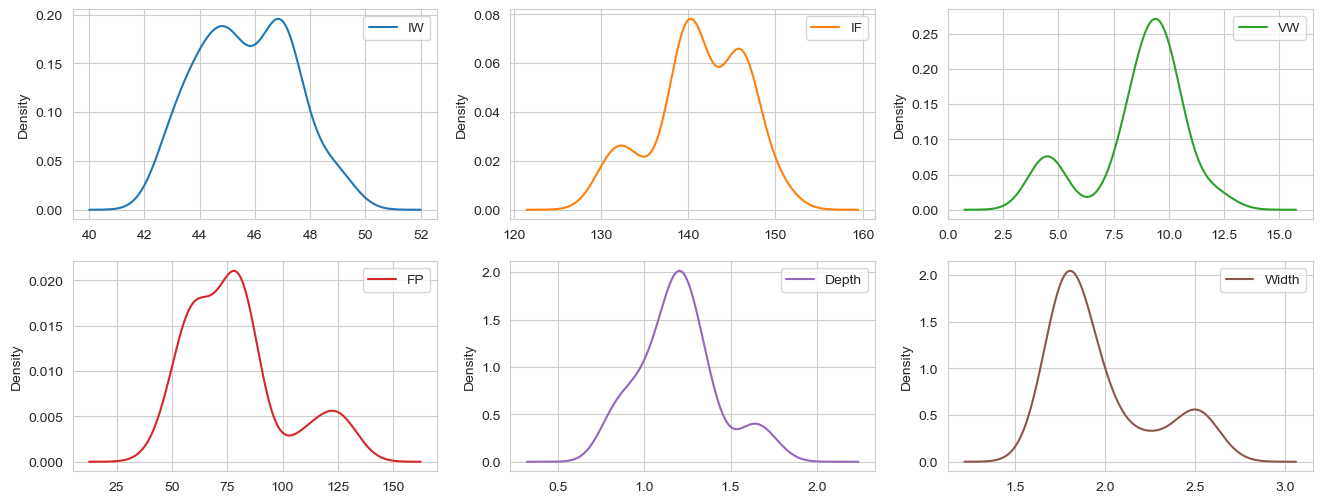

In [7]:
data.plot(kind='density',subplots=True,layout=(2,3),figsize=(16, 6),sharex=False);
#смотрим на распределение

<div class="alert alert-block alert-info"> 
Мы видим, что большинство переменных имеет <a href="https://www.codecamp.ru/blog/multimodal-distribution/">мультимодальное распределение</a>, это говорит о потенциале к разбиению данных на категориальные признаки, также о том, что мы бы не могли пользоваться медианой и средним при заполнении пропусков в данных  <i>(которых, к счастью, нет) </i></div>

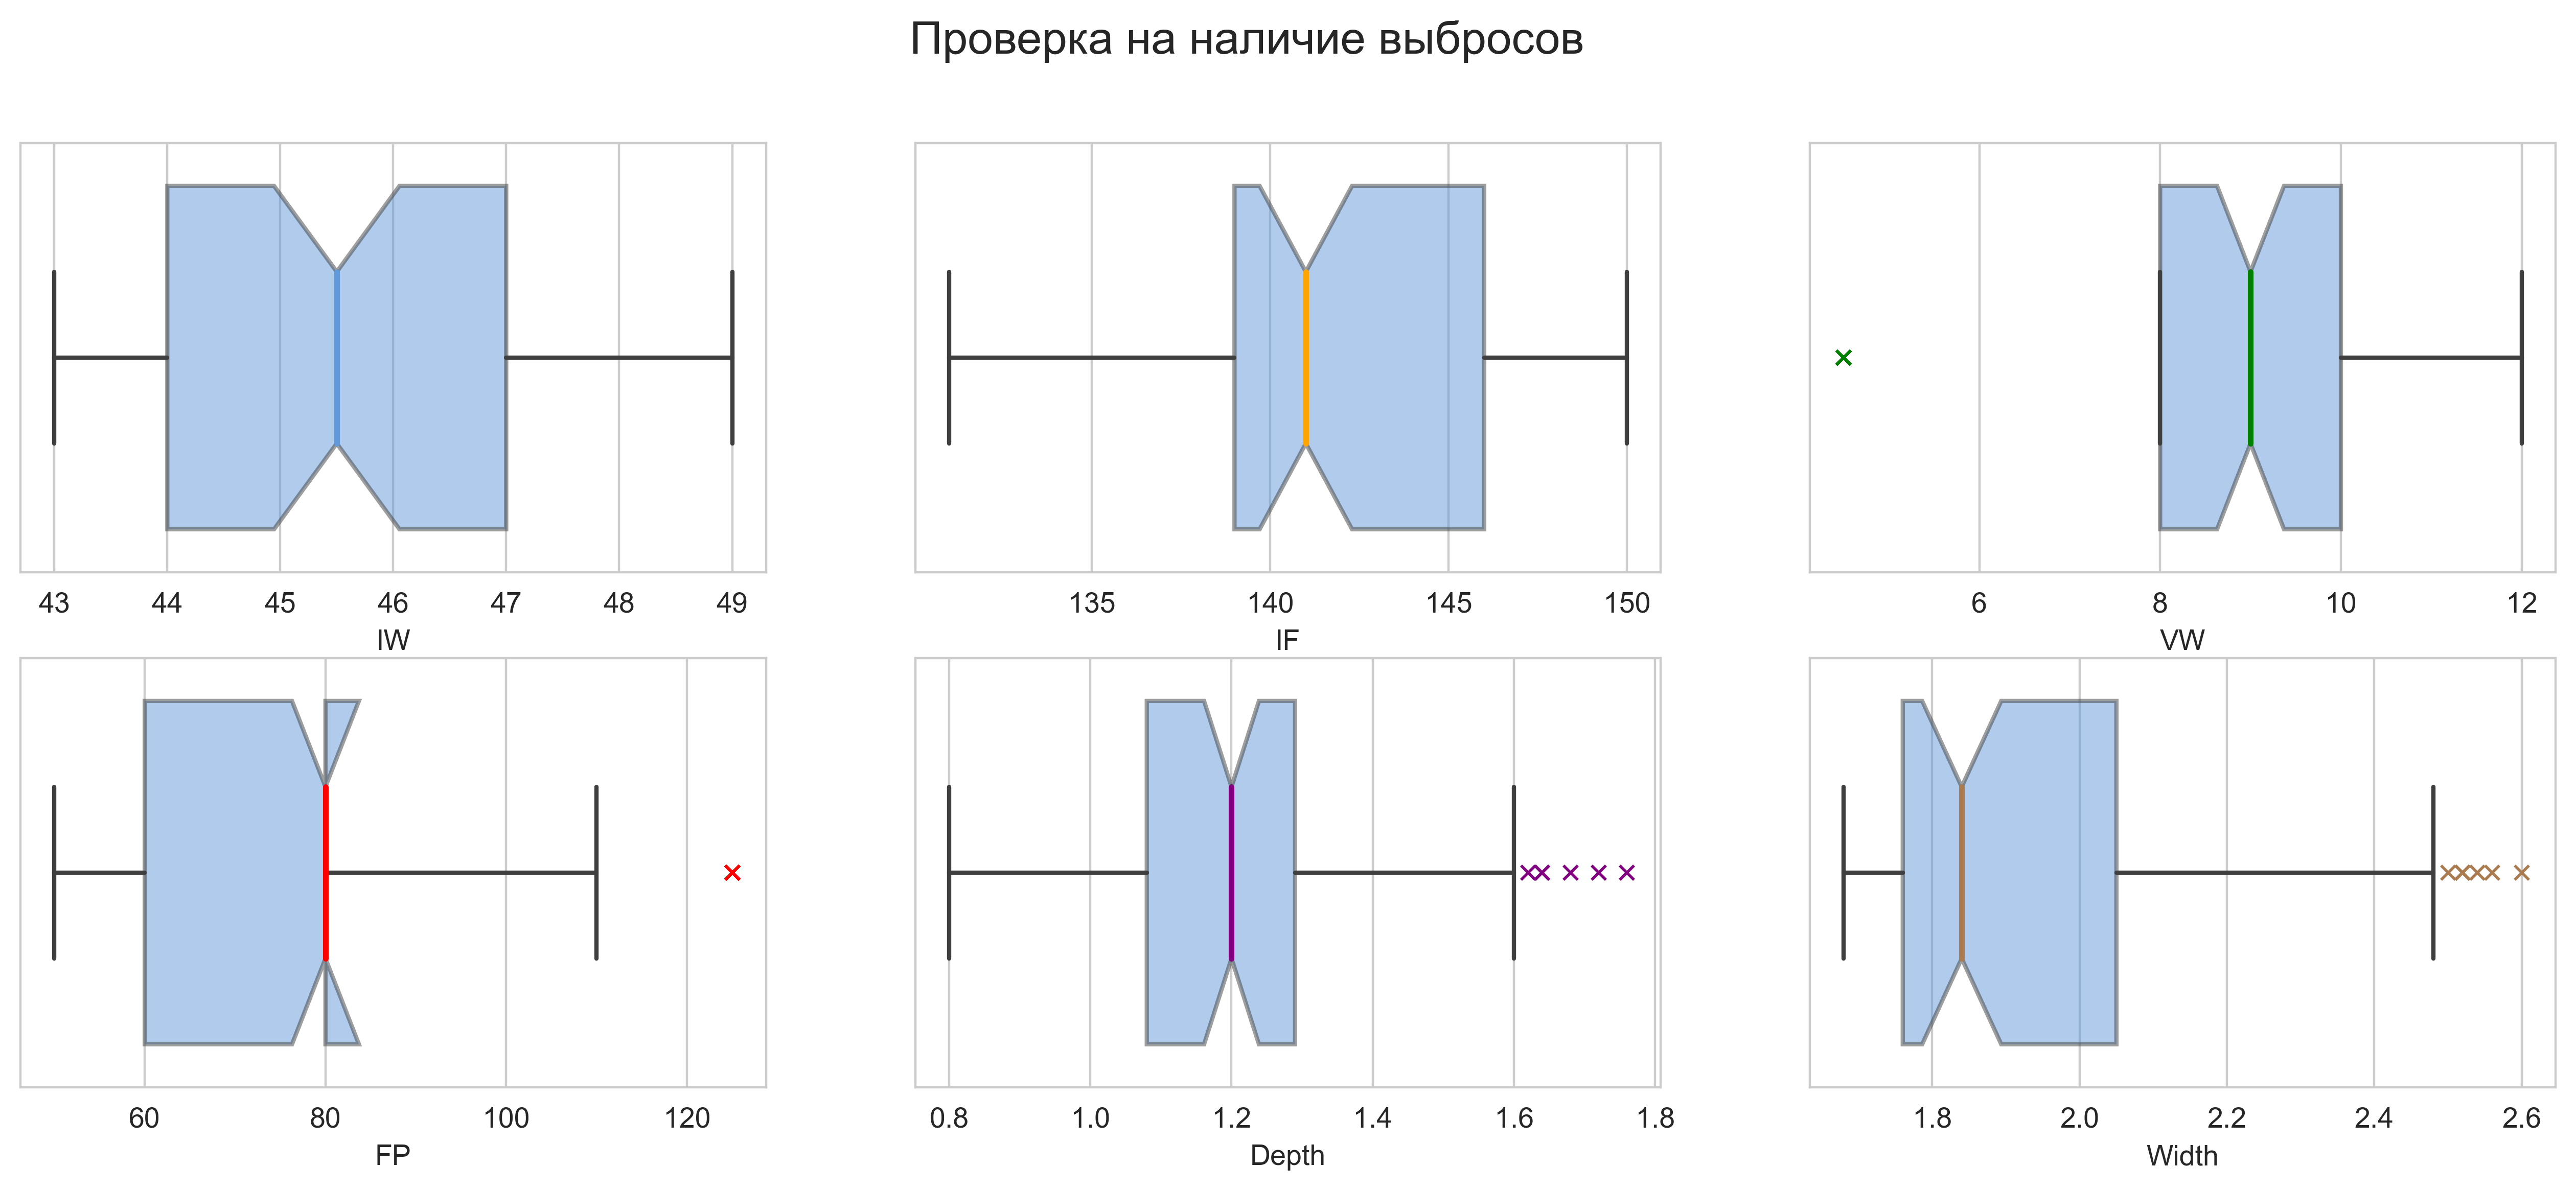

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16, 6), dpi=400,sharex=False)
fig.suptitle('Проверка на наличие выбросов',fontsize=16)

axs=[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
clrs=['#6299d9','orange','green','red','purple','#ab7b50']

for i in range(0,6):  
    sns.boxplot(ax=axes[axs[i]], x=data[data.columns[i]],
               notch=True, 
               flierprops={"marker": "x","markeredgecolor": clrs[i]},
               boxprops={"facecolor": '#6299d9','alpha':0.5},
               medianprops={"color": clrs[i],'linewidth':'2'})    

<div class="alert alert-block alert-info">Зная характер распределения признаков, мы можем говорить о том, что данные, отмеченные в боксплотах как выбросы, на самом деле вторые-верхушики бимодального распределения, и их достаточное кол-во от общего объёма  <i>(даже кажущиеся одинарными зелёный и красный крестики на самом деле — группа данных с одинаковым значением) </i>. Эти данные несут информативную статистику для нашего анализа, поэтому очистка датасетов от выбросов не требуется</div>

In [9]:
data.corr().where((data.corr().abs()>0.5)&
                  (data.corr().abs()!=1)).fillna('')
            #корреляционная таблица из которой исключена рябь неинформативных оценок

IW     IF     VW     FP  Depth  Width
IW           -0.861         0.836              
IF    -0.861               -0.981        -0.510
VW                                -0.671 -0.874
FP     0.836 -0.981               -0.511       
Depth               -0.671 -0.511              
Width        -0.510 -0.874

<Axes: >

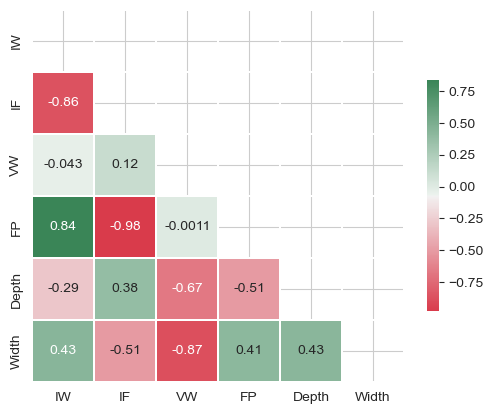

In [10]:
corr = data.corr(numeric_only=True)
# Создадим маску для верхнего треугольника корреляции 
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axes = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(9, 1220, as_cmap=True)# создадим colormap

sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,
            square=True, linewidths=.3, cbar_kws={"shrink": .5})

<div class="alert alert-block alert-info">Мы видим что все данные сильно скоррелированы друг с другом, в обычном статистическом анализе пришлось бы для каждой переменной строить отдельные модели, поскольку данная проблема смещает значения коэффицентов и делает расчёт p-value <a href="https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/#:~:text=Multicollinearity%20makes%20it%20hard%20to,a%20way%20to%20fix%20multicollinearity.">не репрезентативным</a>, для целей предсказания мультиколлинеарность не является критичной проблемой, однако из-за данного явленяи наши доверительные интервалы станут шире(</div>

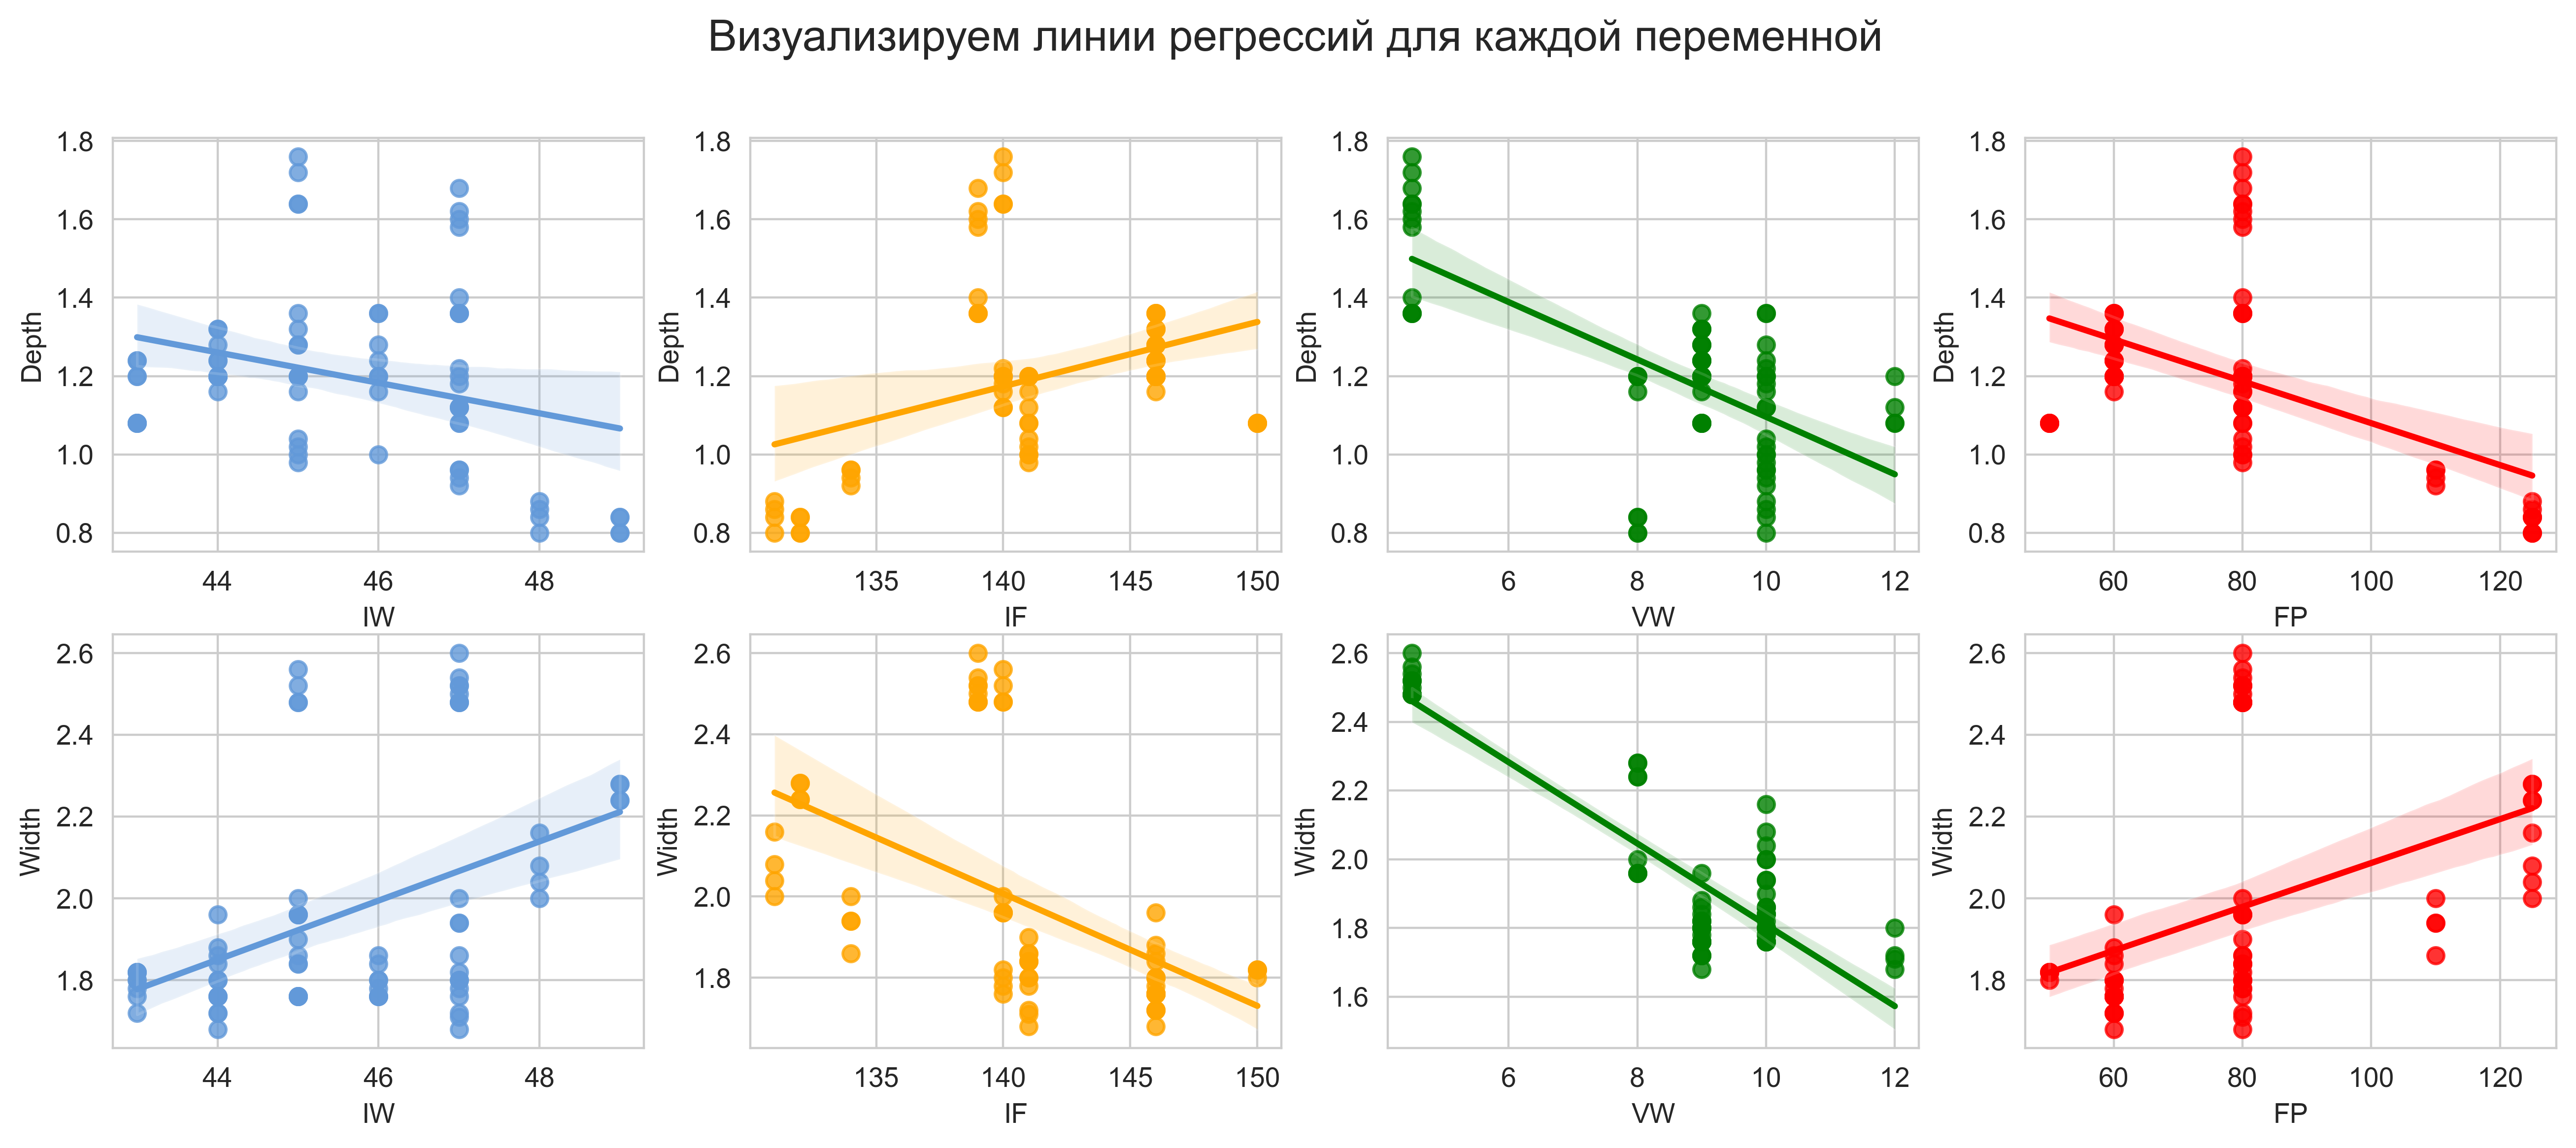

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6),dpi=400, sharex=False)
fig.suptitle('Визуализируем линии регрессий для каждой переменной',fontsize=16)
axs=[(0,0),(0,1),(0,2),(0,3)]
axs2=[(1,0),(1,1),(1,2),(1,3)]

clrs=['#6299d9','orange','green','red']

for i in range(0,4):  
    iks=data[data.columns[i]]
    sns.regplot(data=data,x=iks,y=data.Depth,ax=axes[axs[i]],color=clrs[i], order=1)
    sns.regplot( data=data,x=iks,y=data.Width,ax=axes[axs2[i]],color=clrs[i],order=1)
 


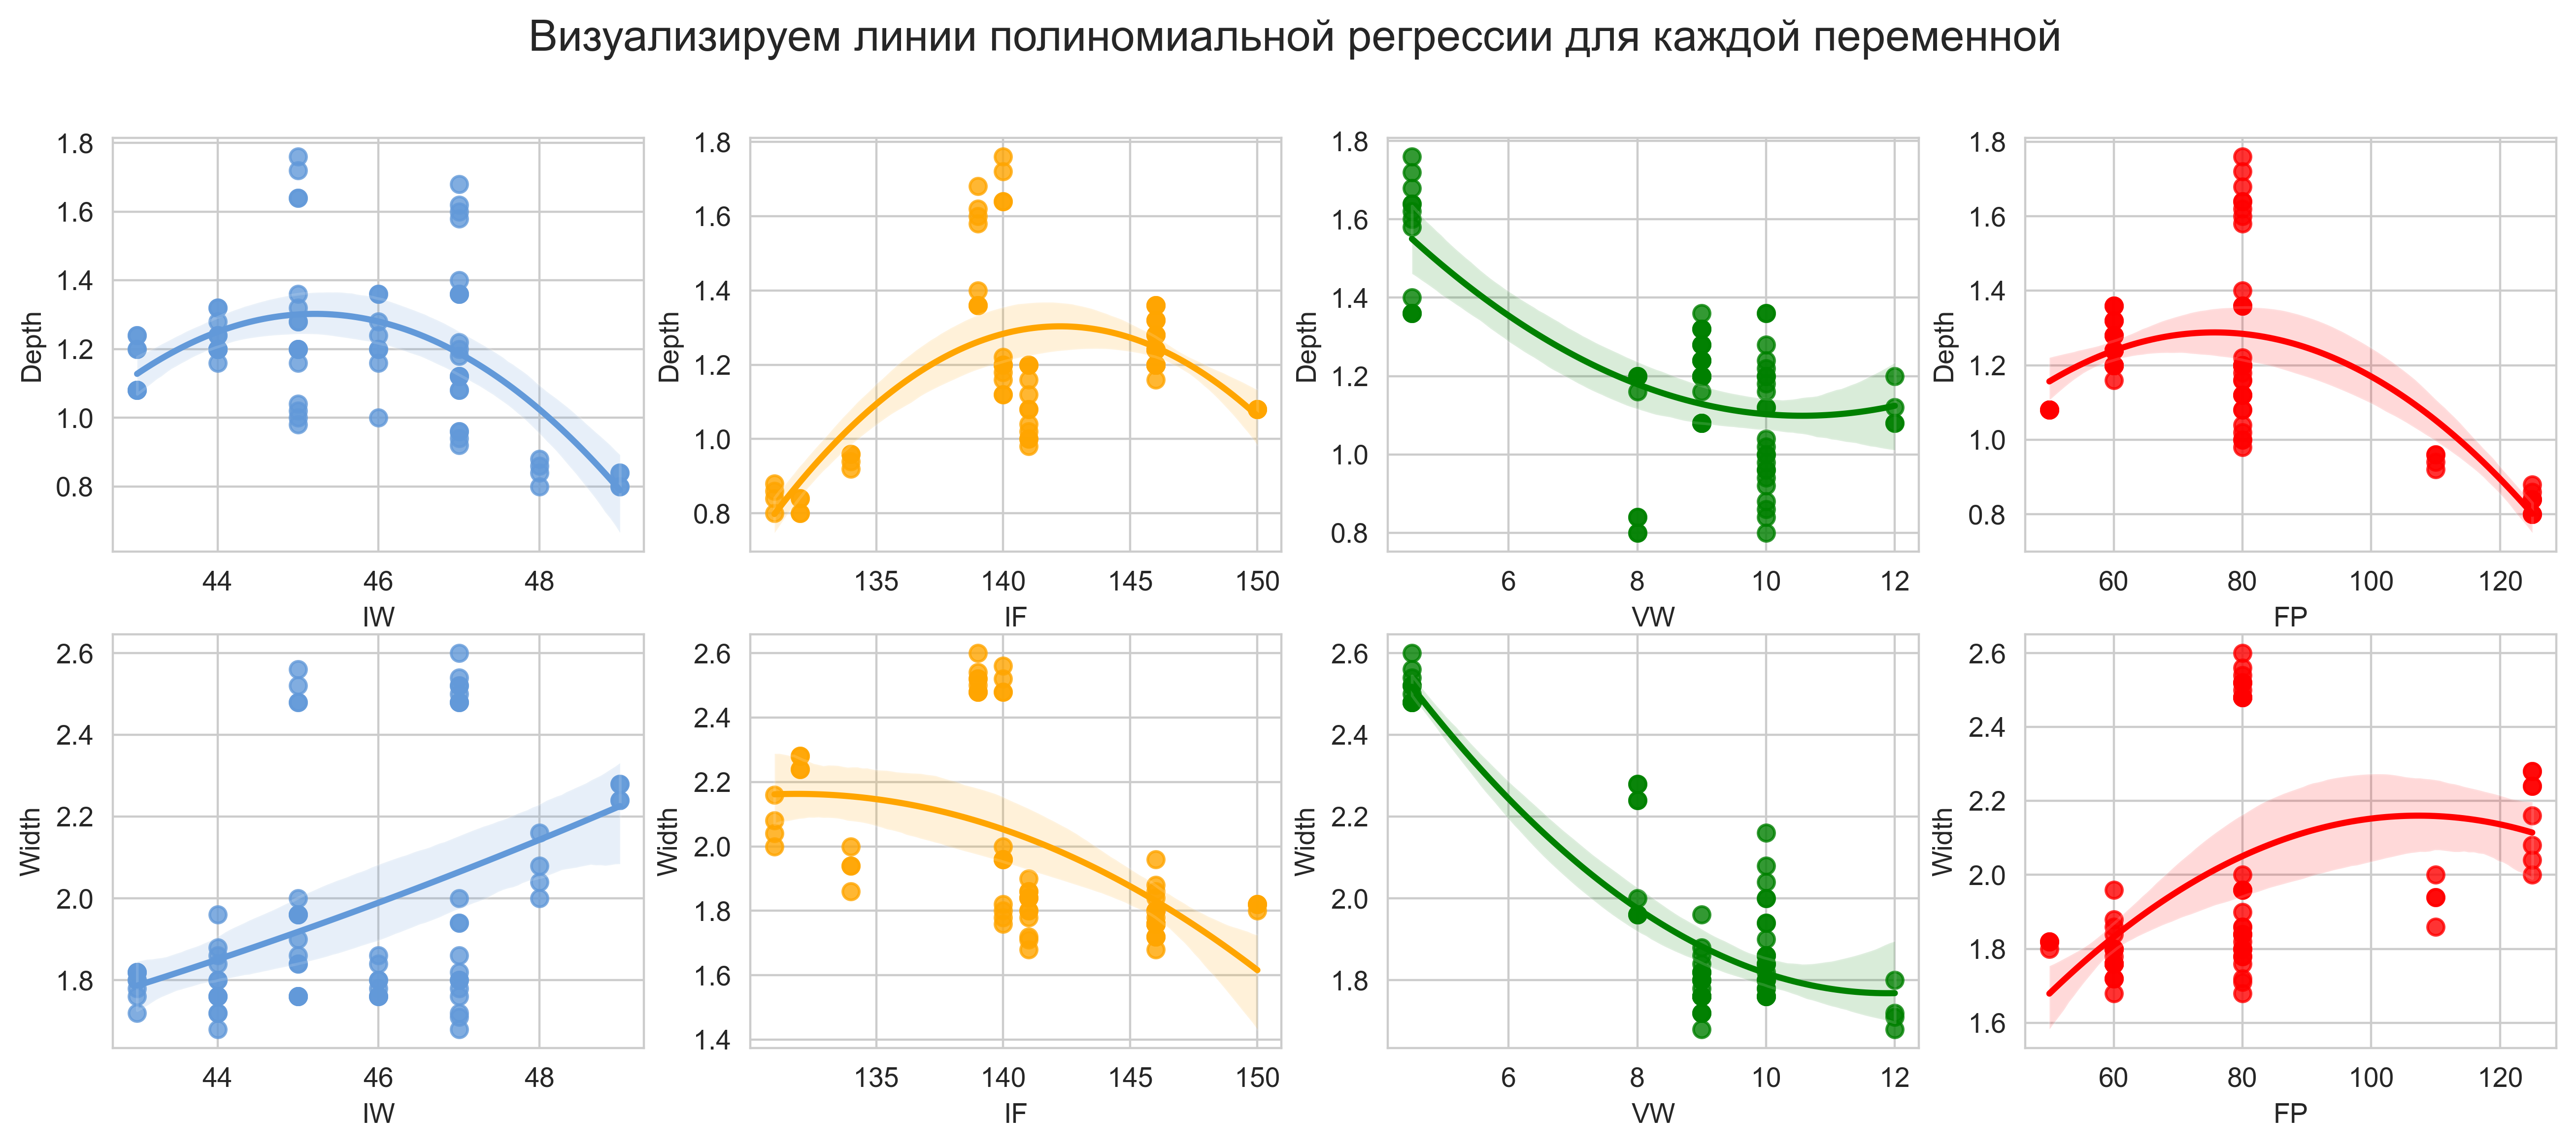

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6),dpi=400, sharex=False)
fig.suptitle('Визуализируем линии полиномиальной регрессии для каждой переменной',fontsize=16)
axs=[(0,0),(0,1),(0,2),(0,3)]
axs2=[(1,0),(1,1),(1,2),(1,3)]

clrs=['#6299d9','orange','green','red']

for i in range(0,4): 
    iks=data[data.columns[i]]
    sns.regplot( data=data,x=iks,y=data.Depth,ax=axes[axs[i]],color=clrs[i], order=2)
    sns.regplot( data=data,x=iks,y=data.Width,ax=axes[axs2[i]],color=clrs[i],order=2)

<div class="alert alert-block alert-info"> Мы видим, что в данных, для обеих наших зависимых переменных действитело прослеживаются линейные зависимости, интересно что эти зависимости в $3/4$ случев имеют разнонаправленный характер <i>(увеличивая ширину, уменьшают глубину и наоборот) </i>, также можно заметить что полиномиальные регрессии <i>(2 порядка)</i> также рисуют неплохие аппроксимации зависимости переменных, примем это во внимание для дальнейшего построения моделей</div>

<div class="alert alert-block alert-info"> Также графики показывают дискретный характер данных, как и бинмодальное распределение, это говорит нам о возможности разбиения признаков на категориальные данные, однако учитывая не большой размер датасета<i> (72 строки данных)</i> подобный фокус может привести нас к <a href="http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8">проклятью размерности</a>, более того, есть подозрение на то, что на самом деле информативных признаков в датасете гораздо меньше. Проверим!</div>

In [13]:
data.groupby(['IW','IF','VW','FP']).agg(['mean','std','var','count']).reset_index()

IW   IF     VW   FP Depth                   Width                  
                         mean   std   var count  mean   std   var count
0   43  146  9.000   60 1.220 0.023 0.001     4 1.765 0.034 0.001     4
1   43  150  9.000   50 1.080 0.000 0.000     4 1.815 0.010 0.000     4
2   44  146  9.000   60 1.230 0.052 0.003    12 1.795 0.079 0.006    12
3   45  140  4.500   80 1.690 0.060 0.004     4 2.510 0.038 0.001     4
4   45  140  8.000   80 1.190 0.020 0.000     4 1.970 0.020 0.000     4
5   45  141 10.000   80 1.010 0.026 0.001     4 1.860 0.028 0.001     4
6   45  146  9.000   60 1.310 0.038 0.001     4 1.760 0.000 0.000     4
7   46  141 10.000   80 1.140 0.095 0.009     4 1.820 0.037 0.001     4
8   46  146 10.000   60 1.310 0.060 0.004     4 1.770 0.020 0.000     4
9   47  134 10.000  110 0.945 0.019 0.000     4 1.935 0.057 0.003     4
10  47  139  4.500   80 1.495 0.137 0.019     8 2.515 0.041 0.002     8
11  47  140 10.000   80 1.160 0.049 0.002     4 1.790 0.026 0.001     4
12  47  141 12.000   80 1.120 0.057 0.003     4 1.728 0.051 0.003     4
13  48  131 10.000  125 0.845 0.034 0.001     4 2.070 0.068 0.005     4
14  49  132  8.000  125 0.820 0.023 0.001     4 2.260 0.023 0.001     4

In [14]:
data['new_column'] = data[['IW','IF','VW','FP']].values.tolist()
data['new_column']="Параметры сварки "+data['new_column'].astype(str)

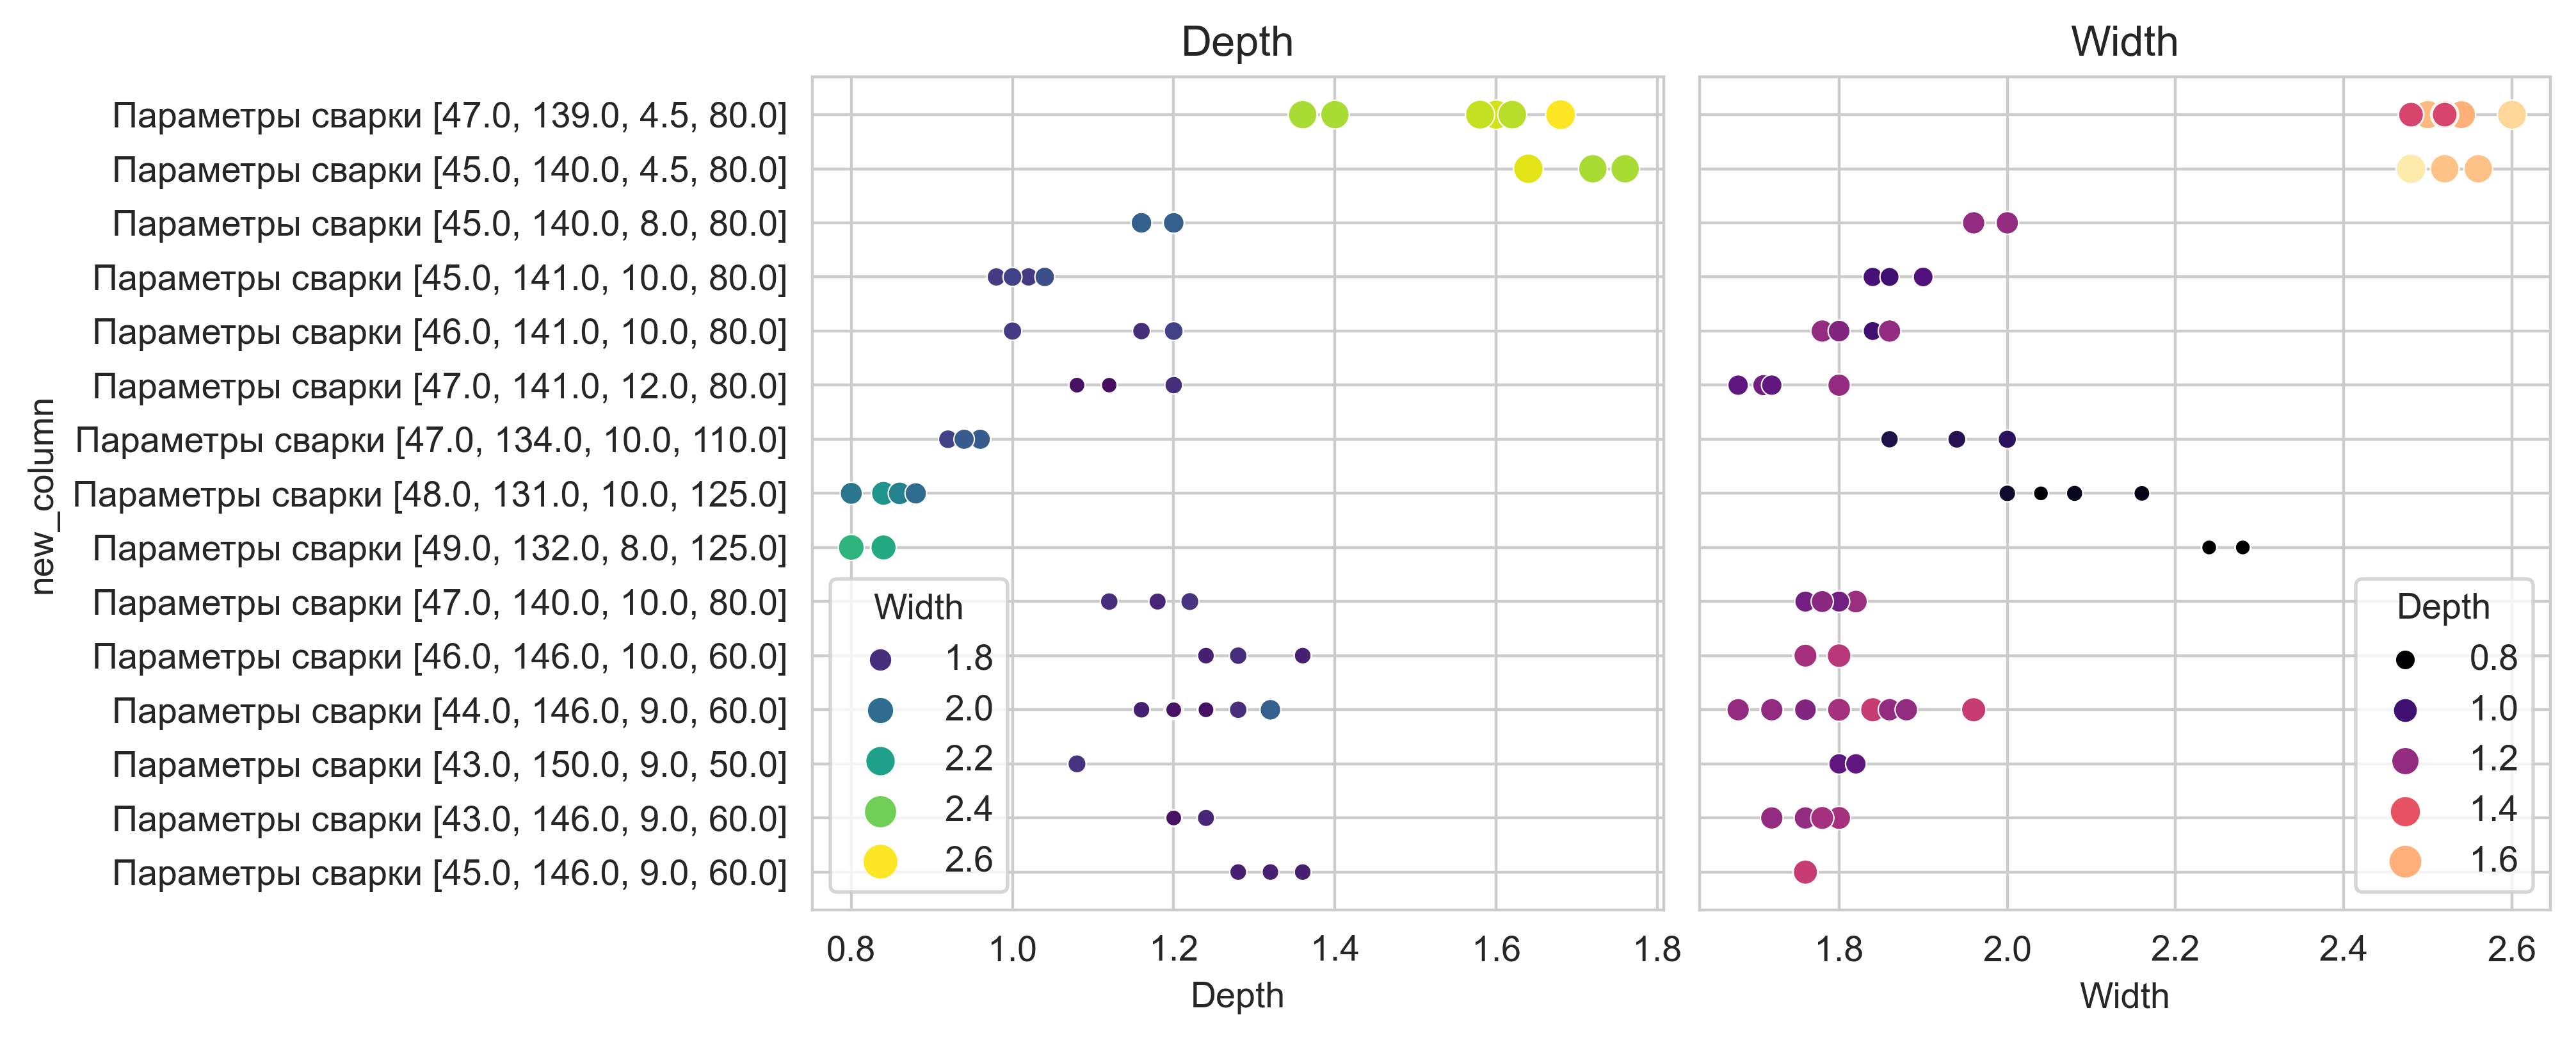

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4),dpi=400, sharey=True)

sns.scatterplot(ax=axes[0],data=data, x="Depth", y="new_column",hue='Width',palette="viridis",size='Width')
axes[0].set_title("Depth")


sns.scatterplot(ax=axes[1],data=data, x="Width", y="new_column",hue='Depth',palette="magma",size='Depth')
axes[1].set_title("Width")
 
fig.tight_layout(pad=.5)

<div class="alert alert-block alert-info"> Опасения подтвердилось, в датасете всего 15 информативных признаков, более того, одни и те же параметры могут приводить к разной глубине и ширине сварного шва, при некторых параметрах дисперсия зависимой переменной довольна высока. Это на берегу говорит нам о том, что потрясающего качества модели достичь нельзя, возможно пропущены какие-то значимые переменные, следовательно коэффицент детерминации модели также будет не велик.

Интереса ради, создадим датафрейм <b>data_small</b> с уникальными независимыми переменными, а для зависимых переменных усредним значения Глубины и Ширины шва, в дальнешйем пообучаем регрессионные модели и на этом небольшом датасете и предсказательную силу с моделями обучающимися на полной выборке
</div>


In [16]:
data_small=data.groupby(['IW','IF','VW','FP']).agg('mean',numeric_only=True).reset_index()
data_small.columns=['IW','IF','VW','FP','avDepth','avWidth']

<div class="alert alert-block alert-info"> Мы помним, что у зависимых переменных тоже наблюдается небольшая корреляция <i>(.43)</i>, визуализируем линейную зависимость между ними
</div>

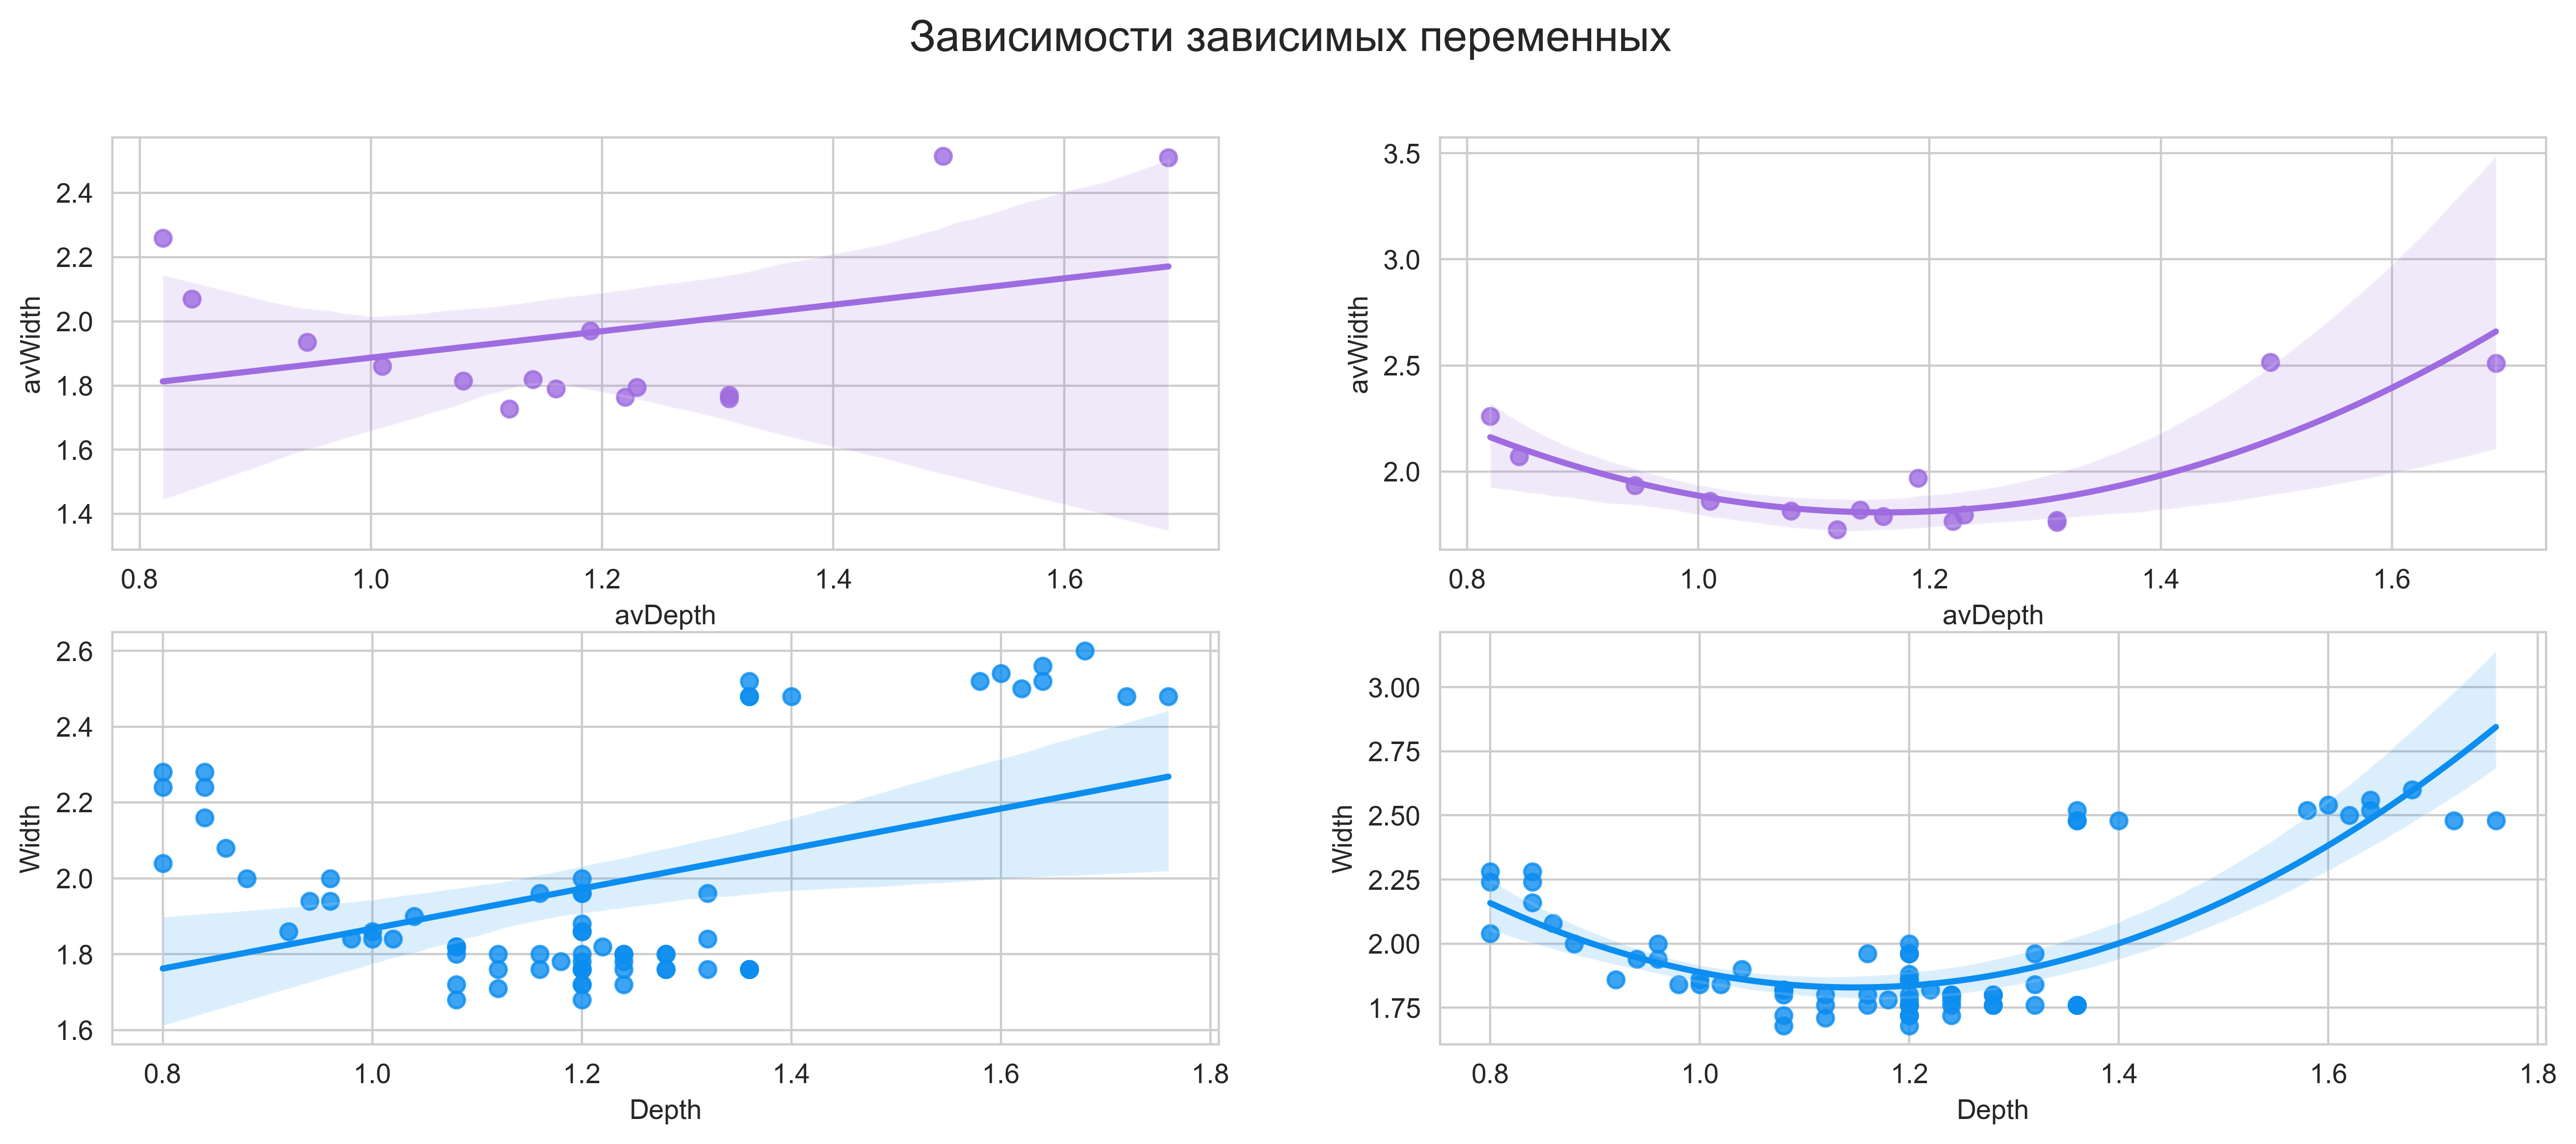

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6),dpi=400, sharex=False)
fig.suptitle('Зависимости зависимых переменных',fontsize=16)
axs=[(0,0),(0,1)]
axs2=[(1,0),(1,1)]

for i in range(0,2): 
    sns.regplot(data=data_small,x="avDepth",y="avWidth",ax=axes[axs[i]],color='#9e6ce0', order=i+1)
    sns.regplot(data=data,x="Depth",y="Width",ax=axes[axs2[i]],color='#0c8df0',order=i+1)

<div class="alert alert-block alert-info"> Графики подсказывают о нелинейной зависимости переменных <i>(возможно есть смысл включить предсказание по одной из переменных в независимые признаки для другой)</i>, также графики говорят о значительном увеличении доверительного интервала при построении регрессии на датасете <b>data_small</b>, что логично, учитывая низкую плотность данных.
</div>

<div class="alert alert-block alert-info"><h3>Нормализация</h3> 
Не стандартизация потому, что распределение признаков не Гауссовское</div>

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [19]:
min_max_scaler = MinMaxScaler()

X=min_max_scaler.fit_transform(np.array(data[['IW','IF','VW','FP']]))
y_w=np.array(data.Width)
y_d=np.array(data.Depth)


Xs=min_max_scaler.fit_transform(np.array(data_small[['IW','IF','VW','FP']]))#Нормализуем иксы
ys_w=np.array(data_small.avWidth)
ys_d=np.array(data_small.avDepth)

<div class="alert alert-block alert-success"><h3>Строим модели</h3> </div>

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [22]:
model_quality=[]# для создания датасета с качеством моделей

<div class="alert alert-block alert-success"><h3>LinearRegression()</h3> </div>

<div class="alert alert-block alert-success">Начнём со станадартной линейной регрессии, представленный внизу код, сто раз строит модели для каждой из зависимой переменной, а затем устредняет по ним функционал качества и коэффицент детерминации,такой топорный кросс-валидейшн был сделан постольку поскольку у нас мало данных и при повторном запуске одной и той же модели без указания <b>random_state</b> были замечены значительные флуктуации в оценках качества модели. Это говорит о неустойчивости регрессионной модели, небольшие потери в данных для тестовой выборки смещают её оценки. Топорным кроссвалидейшином ориетируясь на ЗБЧ мы можем представить более реальное представление о предсказательной мощности модели. Почему не cross-validation из библиотеки skir-learn, потому-что на проверку он оказался ещё более неустойчивым и чрезвычайно сильно зависел от кол-ва разбиений выборки!</div>

In [23]:
linear_model = LinearRegression()

for ygrik in [y_w,y_d]:
    MSE=[]
    MAE=[]
    R2=[]
    for i in range(1,100): # своебразный кросс валидейшн, больше напоминающий бутстреппинг
        # делается затем что оценки модели не постоянные
        # особенно r2_score 
        X_train, X_test, y_train, y_test = train_test_split(X, ygrik, test_size=0.3,shuffle=True)
        model=linear_model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        R2.append(r2_score(y_test,y_pred))
        MAE.append(mean_absolute_error(y_test,y_pred))
        MSE.append(mean_squared_error(y_test,y_pred))  
        
    #записываем данные в обощенный датасет моделей
    qual={
          'Model': 'LinearRegression',
          'Data': 'full',
          'Y': "depth" if str(y_d)==str(ygrik) else 'width',
          'MSE': round(np.mean(MSE),4),
          'MAE':round(np.mean(MAE),4),
          "R2":round(np.mean(R2),4)
                 }
    model_quality.append(qual) 

In [24]:
# ТОТ же процесс повторяем для игриков из урезанного датасета
# Тренируем модель на всём наобре данных из data_small 
# Тестируем на 
for ygrik in [[y_w,ys_w],[y_d,ys_d]]:
    MSE=[]
    MAE=[]
    R2=[]
    for i in range(1,100): 
        X_train, X_test, y_train, y_test = train_test_split(X, ygrik[0], test_size=0.3,shuffle=True)# Из большого датасета!
        
        model=linear_model.fit(Xs, ygrik[1]) # Xs
        y_pred = model.predict(X_test)# Проверяем на большом датасете! #X
        
        R2.append(r2_score(y_test,y_pred))
        MAE.append(mean_absolute_error(y_test,y_pred))
        MSE.append(mean_squared_error(y_test,y_pred))    
    qual={
          'Model': 'LinearRegression',
          'Data': 'small',
          'Y': "depth" if str(y_d)==str(ygrik[0]) else 'width',
          'MSE': round(np.mean(MSE),4),
          'MAE':round(np.mean(MAE),4),
          "R2":round(np.mean(R2),4)
                 }
    model_quality.append(qual) 

<div class="alert alert-block alert-success"><h3>PolynomialRegression()</h3> </div>

<div class="alert alert-block alert-success">Помня про красивые изогнутые линии полиномиальной зависимости на графиках выше проверим и предсказательные способности полиномиальной регрессии 2 порядка <i>(порядок выбрали ориентируясь на визуальную оценку данных)</i></div>

In [25]:
from sklearn.preprocessing import PolynomialFeatures

In [26]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_X = poly.fit_transform(X)

In [27]:
for ygrik in [y_w,y_d]:
    MSE=[]
    MAE=[]
    R2=[]
    for i in range(1,10): # интересно что при 100 итерации мы можем получить отвратительное среднее качество
        # при каком-то из разиений модель ломается и вадаёт неадекватные параметры MAE,MSE смещающие
        # все оценки 
        X_train, X_test, y_train, y_test = train_test_split(poly_X, ygrik, test_size=0.3,shuffle=True)
        
        model=linear_model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        R2.append(r2_score(y_test,y_pred))
        MAE.append(mean_absolute_error(y_test,y_pred))
        MSE.append(mean_squared_error(y_test,y_pred))    
    qual={
          'Model': 'PolyRegression',
          'Data': 'full',
          'Y': "depth" if str(y_d)==str(ygrik) else 'width',
          'MSE': round(np.mean(MSE),4),
          'MAE':round(np.mean(MAE),4),
          "R2":round(np.mean(R2),4)
                 }
    model_quality.append(qual)

In [28]:
poly_Xs = poly.fit_transform(Xs)

In [29]:
for ygrik in [[y_w,ys_w],[y_d,ys_d]]:
    MSE=[]
    MAE=[]
    R2=[]
    for i in range(1,100): # на маленьких данных при полинромиальной регрессии  проблемы смещения данных
                           # при большом количестве построений содели не возникает
                           # скорей всего в основных данных есть не обнаруженный нами выброс
                
        X_train, X_test, y_train, y_test = train_test_split(poly_X, ygrik[0], test_size=0.3,shuffle=True)
        
        model=linear_model.fit(poly_Xs, ygrik[1])
        y_pred = model.predict(X_test)# Проверяем на большом датасете!
        
        R2.append(r2_score(y_test,y_pred))
        MAE.append(mean_absolute_error(y_test,y_pred))
        MSE.append(mean_squared_error(y_test,y_pred))    
    qual={
          'Model': 'PolyRegression',
          'Data': 'small',
          'Y': "depth" if str(y_d)==str(ygrik[0]) else 'width',
          'MSE': round(np.mean(MSE),4),
          'MAE':round(np.mean(MAE),4),
          "R2":round(np.mean(R2),4)
                 }
    model_quality.append(qual) 

<div class="alert alert-block alert-success"><h3>KNeighborsRegressor()</h3> </div>

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [31]:
for ygrik in [y_w,y_d]:
    MSE=[]
    MAE=[]
    R2=[]
    for i in range(1,100): 
        X_train, X_test, y_train, y_test = train_test_split(X, ygrik, test_size=0.3,shuffle=True)
        KN_model = KNeighborsRegressor()
        grid_search = GridSearchCV(KN_model,
                           param_grid={"n_neighbors": range(1, 20)},
                           scoring="neg_mean_squared_error",
                           cv=5)
        grid_search.fit(X_train, y_train)
        numb_est=grid_search.best_estimator_.n_neighbors
        
        KN_model = KNeighborsRegressor(n_neighbors=numb_est)
        model=KN_model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        R2.append(r2_score(y_test,y_pred))
        MAE.append(mean_absolute_error(y_test,y_pred))
        MSE.append(mean_squared_error(y_test,y_pred))    
    qual={
          'Model': 'KNeighborsRegr',
          'Data': 'full',
          'Y': "depth" if str(y_d)==str(ygrik) else 'width',
          'MSE': round(np.mean(MSE),4),
          'MAE':round(np.mean(MAE),4),
          "R2":round(np.mean(R2),4)
                 }
    model_quality.append(qual)

In [32]:
for ygrik in [[y_w,ys_w],[y_d,ys_d]]:
    MSE=[]
    MAE=[]
    R2=[]
    for i in range(1,100): 
        X_train, X_test, y_train, y_test = train_test_split(X, ygrik[0], test_size=0.3,shuffle=True)# Из большого датасета!
        
        KN_model = KNeighborsRegressor()
        grid_search = GridSearchCV(KN_model,
                           param_grid={"n_neighbors": range(1, 5)},
                           scoring="neg_mean_squared_error",
                           cv=10)
        grid_search.fit(Xs, ygrik[1])
        numb_est=grid_search.best_estimator_.n_neighbors
        
        KN_model = KNeighborsRegressor(n_neighbors=numb_est)
        model=KN_model.fit(Xs, ygrik[1])# Xs
        y_pred = model.predict(X_test)# Проверяем на большом датасете! #X
            
        R2.append(r2_score(y_test,y_pred))
        MAE.append(mean_absolute_error(y_test,y_pred))
        MSE.append(mean_squared_error(y_test,y_pred))    
    qual={
          'Model': 'KNeighborsReg',
          'Data': 'small',
          'Y': "depth" if str(y_d)==str(ygrik[0]) else 'width',
          'MSE': round(np.mean(MSE),4),
          'MAE':round(np.mean(MAE),4),
          "R2":round(np.mean(R2),4)
                 }
    model_quality.append(qual) 

In [33]:
m_Q=pd.DataFrame(model_quality)
m_Q

Model   Data      Y   MSE   MAE    R2
0   LinearRegression   full  width 0.005 0.059 0.926
1   LinearRegression   full  depth 0.012 0.083 0.741
2   LinearRegression  small  width 0.004 0.054 0.936
3   LinearRegression  small  depth 0.011 0.077 0.769
4     PolyRegression   full  width 0.004 0.043 0.937
5     PolyRegression   full  depth 0.006 0.057 0.873
6     PolyRegression  small  width 0.002 0.030 0.974
7     PolyRegression  small  depth 0.003 0.042 0.927
8     KNeighborsRegr   full  width 0.004 0.047 0.942
9     KNeighborsRegr   full  depth 0.007 0.062 0.856
10     KNeighborsReg  small  width 0.002 0.030 0.975
11     KNeighborsReg  small  depth 0.003 0.042 0.926

Text(0.5, 1.0, 'MAE on small data')

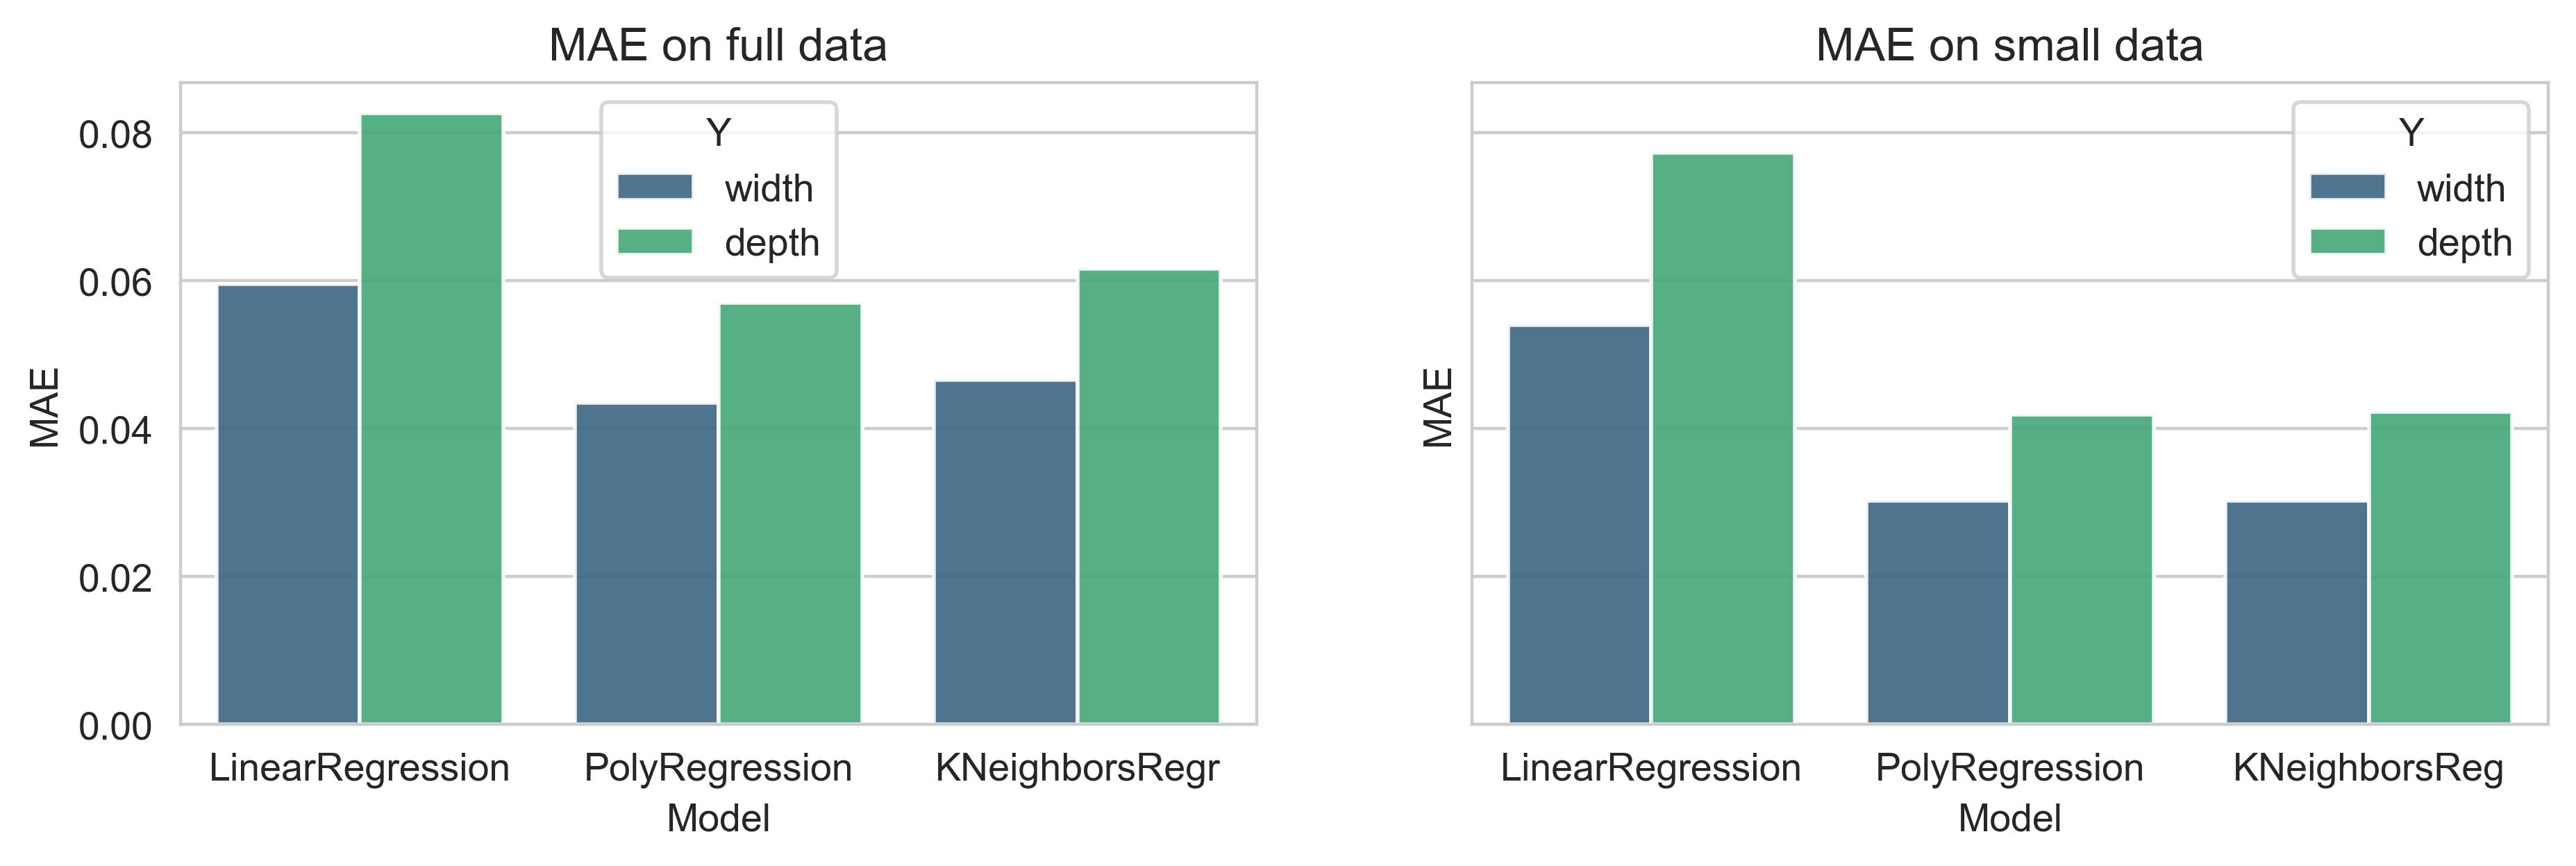

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3),dpi=400, sharey=True)
sns.barplot(ax=axes[0],data=m_Q.where(m_Q.Data=='full'),x='Model',y='MAE',hue='Y',palette = "viridis",alpha=0.9)
axes[0].set_title("MAE on full data")
sns.barplot(ax=axes[1],data=m_Q.where(m_Q.Data=='small'),x='Model',y='MAE',hue='Y',palette = "viridis",alpha=0.9)
axes[1].set_title("MAE on small data")

In [35]:
std_w=data.groupby(['IW','IF','VW','FP']).agg('std').Width.mean()
std_d=data.groupby(['IW','IF','VW','FP']).agg('std').Depth.mean()
print(f'Стандартное отклонение в значениях Depth = {std_d}')
print(f'Стандартное отклонение в значениях Width = {std_w}')
# напомним стандартные отклонения значений зависимых переменных при одних и тех же предикторах

Стандартное отклонение в значениях Depth = 0.046208463031442756
Стандартное отклонение в значениях Width = 0.03555737132726758


<div class="alert alert-block alert-success"> Предварительно мы видим, что предсказательная способность модели неплохая,вс
MAE начинается со свторого знака после запятой как и среднеквадратичное отклонение в данных <i>(при одних и тех же предикторах)</i> и даже есть модель c MAE чуть меньше данных отклонений а именно Полиномиальная Регрессия обученная на "маленьких" данных, но проверенная на сотне тестовых выборок из основного датасета. С другой стороны лучшая работа "маленького" датасета может быть объяснена тем, что в нашем дизайне построения моделей он не разбивается на тестовую и тренинговую выборку, а обучается на всех данных, проверить надежность данной модели можно изаользуя отложеенные данные, которых модель не увидит. Делать вид, что моедли обученные на всём датасете надёжней тоже не стоит, хотя в них есть тест трейн спплит, мы помним, что все из возможных 15 последовательностей параметров попадают к нам в тренинговую выборку, и модель фактически не видит новых данных на тесте! <i>(об этом же свидетельсвует, то что моель полного датасета крашится на множественных интерациях полиномиальной регрессии)</i></div> 

<div class="alert alert-block alert-success"> Так выберем же одну из наших лучших предсказательных моделей, и проведём эесперимент насколько она устойчива к неведанным данным! LeaveOneOut Cross Validation может ответить нам на данный вопрос </div>

In [36]:
from sklearn.model_selection import LeaveOneOut

In [37]:
# Лив уан оут на линейной регрессии
cv = LeaveOneOut()
model = LinearRegression()
scores_w = cross_val_score(model, Xs, ys_w, scoring='neg_mean_absolute_error',
                         cv=cv)
scores_d = cross_val_score(model, Xs, ys_d, scoring='neg_mean_absolute_error',
                         cv=cv)
#MAE
mae_w,mae_d=np.mean(abs(scores_w)),np.mean(abs(scores_d))
print(f"MAE ширины равна {round(mae_w,4)}\nMAE глубины равна {round(mae_d,4)}")


MAE ширины равна 0.0751
MAE глубины равна 0.1155


In [38]:
# Лив уан оут на полиномиальной регрессии
poly_Xs = poly.fit_transform(Xs)
cv = LeaveOneOut()
model = LinearRegression()
scores_w = cross_val_score(model, poly_Xs, ys_w, scoring='neg_mean_absolute_error',
                         cv=cv)
scores_d = cross_val_score(model, poly_Xs, ys_d, scoring='neg_mean_absolute_error',
                         cv=cv)
#MAE
mae_w,mae_d=np.mean(abs(scores_w)),np.mean(abs(scores_d))
print(f"MAE ширины равна {round(mae_w,4)}\nMAE глубины равна {round(mae_d,4)}")

MAE ширины равна 0.1986
MAE глубины равна 0.4548


<div class="alert alert-block alert-success"> Как и ожидалось качество модели сильно упало, однако предсказание ширины обычной
линейной моделью даёт довольно неплохие результаты <b>.0751</b>, что говорит о том, что модель в целом неплохая и нашла какие-то зависимости, а вот над предсказание глубины ещё можно поработать</div>

<div class="alert alert-block alert-success"> Поработаем, для этого используем предсказанный параметр Ширины шва в качестве предиктора для Глубины шва</div>

In [39]:
cv = LeaveOneOut()
model = LinearRegression()
scores_w = cross_val_score(model, Xs, ys_w, scoring='neg_mean_absolute_error',
                         cv=cv)
print("MAE of Width =", np.mean(abs(scores_w)))
reg=model.fit(Xs, ys_w)# Xs
w_pred=reg.predict(Xs)

dta=pd.DataFrame(Xs)
dta['P_w']=w_pred
newX=min_max_scaler.fit_transform(np.array(dta))

MAE of Width = 0.07508825722543913


In [40]:
scores_d = cross_val_score(model, newX, ys_d, scoring='neg_mean_absolute_error',
                         cv=cv)
print("MAE of Depth =",np.mean(abs(scores_d))) # нам удалось незначительно улучшить качетсво модели

MAE of Depth = 0.11726174722445024


<div class="alert alert-block alert-success"> Таким образом  получилось немного улучшить предсказание Глубины.</div>

<div class="alert alert-block alert-success"> <h3>Вывод</h3>
    Нам попался увлекательный датсает, в котором одни и те же последовательности независимых переменных имёют различное значение зависимой, проблема обучения данного датасета заключалась в правильной стратегии разбиения датасета на test train, поскольку нельзя было быть уверенным в том,  что мы исключили все из 15 имеющихся последовательностей в независимых переменных -> не факт что модель бы тестировалась на неизвестных ей данных -> качество такой моделей весьма спорно, неизвестно как бы она повела себя на данных которых она не видела.</div>

<div class="alert alert-block alert-success"> Тем не менее нам удалось построит модель сократив датасет до 15 наблюдений и на LeaveOneOut кросс валидации доказать состоятельность его оценок <i>(даже на неизвестных ему данных)</i> Итоговой средней абсолютной ошибкой для глубины шва стал показатель<b>.11</b>, для ширины <b>.07</b> возможно это не такие уж и ужасные показатели <i>(тут лучше проконсультироваться с экспертами)</i></div>